In [1]:
! pip install --quiet "ipython[notebook]>=8.0.0, <8.17.0" "urllib3" "matplotlib" "torchmetrics>=0.7, <1.3" "torch>=1.8.1, <2.1.0" "pytorch-lightning>=1.4, <2.1.0" "lightning>=2.0.0" "matplotlib>=3.0.0, <3.9.0" "torchvision" "setuptools>=68.0.0, <68.3.0" "seaborn"

# 초기화와 최적화

In [4]:
import copy
import json
import math
import os
import urllib.request
from urllib.error import HTTPError

import lightning as L
import matplotlib.pyplot as plt

%matplotlib inline
import matplotlib_inline.backend_inline
import numpy as np 
import seaborn as sns 
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.utils.data as data 
from matplotlib import cm 
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from tqdm.notebook import tqdm

matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")
sns.set()

In [5]:
# 데이터셋이 담길 폴더 경로
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")
# 사전 훈련된 모델이 저장된 경로
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/InitOptim/")

# seed
L.seed_everything(42)

# 모든 연산이 재현성을 위해 GPU에서 결정론적으로 구현되도록 함.
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 이 노트북에서 사용될 디바이스를 가져온다.
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Seed set to 42


Using device cuda:0


In [6]:
# 이 튜토리얼에서 저장된 모델이 담긴 Github URL
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial4/"
# 다운 받을 파일
pretrained_files = [
    "FashionMNIST_SGD.config",
    "FashionMNIST_SGD_results.json",
    "FashionMNIST_SGD.tar",
    "FashionMNIST_SGDMom.config",
    "FashionMNIST_SGDMom_results.json",
    "FashionMNIST_SGDMom.tar",
    "FashionMNIST_Adam.config",
    "FashionMNIST_Adam_results.json",
    "FashionMNIST_Adam.tar",
]
# 존재하지 않으면 체코포인트 경로 만들기
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# 각 파일이 이미 존재하는지 확인한다. 만약 없다면 다운한다.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print(
                "Something went wrong. Please try to download the file from the GDrive folder, or conteact the author with the full output including the following error:\n",
                e,    
            ) 

## 준비

In [7]:
# 각 이미지 변환 -> 텐서로 만들고, 평균 0, 분산 1로 정규화한다.
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.2861,), (0.3530,))])

# 훈련셋 가져오기. 훈련, 검증 세트로 분리한다.
train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# 테스트셋 가져오기
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

In [16]:
# Transformations applied on each image => first make them a tensor, then normalize them with mean 0 and std 1
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.2861,), (0.3530,))])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

In [17]:
train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)

이전의 예시에서와는 달리 ```transforms.Normalize```로 파라미터를 정규화시킴.
대부분의 분류작업에서는 정규화 기술(-1~1 사이, 평균 0, stddev 1)이 효율을 높여줌.

In [18]:
print("Mean", (train_dataset.data.float() / 255.0).mean().item())
print("Std", (train_dataset.data.float() / 255.0).std().item())

Mean 0.28604060411453247
Std 0.3530242443084717


In [19]:
imgs, _ = next(iter(train_loader))
print(f"Mean: {imgs.mean().item():5.3f}")
print(f"Standard deviation: {imgs.std().item():5.3f}")
print(f"Maximum: {imgs.max().item():5.3f}")
print(f"Minimum: {imgs.min().item():5.3f}")

Mean: -0.003
Standard deviation: 0.999
Maximum: 2.022
Minimum: -0.810


최댓값과 최솟값이 -1~1 사이가 아니라 양수 값으로 이동 함.
이는 FashionMNIST가 MNIST와 유사하게 검은 픽셀이 많기 때문.

In [20]:
class BaseNetwork(nn.Module):
    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        """Base Network.
        
        Args:
            act_fn: 네트워크에서 ...로 사용되는 활성화 함수의 객체
            input_size: 입력 이미지의 픽셀 크기
            num_classes: 예측하려는 클레스의 숫자
            hidden_size: 신경망에서 hidden layer 크기를 지정하는 정수 리스트
        """
        super().__init__()

        # 지정된 hidden 크기를 기반으로 망을 만든다.
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index - 1], layer_sizes[layer_index]), act_fn]
            layers += [nn.Linear(layer_sizes[-1], num_classes)]
            # 
        self.layers = nn.ModuleList(layers)

        self.config = {
            "act_fn": act_fn.__class__.__name__,
            "input_size": input_size,
            "num_classes": num_classes,
            "hidden_sizes": hidden_sizes,
        }

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for layer in self.layers:
            x = layer(x)
        return x

In [21]:
class Identity(nn.Module):
    def forward(self, x):
        return x
    
act_fn_by_name = {"tanh": nn.Tanh, "relu": nn.ReLU, "identiity": Identity}

In [22]:
##############################################################


def plot_dists(val_dict, color="C0", xlabel=None, stat="count", use_kde=True):
    columns = len(val_dict)
    fig, ax = plt.subplots(1, columns, figsize=(columns * 3, 2.5))
    fig_index = 0
    for key in sorted(val_dict.keys()):
        key_ax = ax[fig_index % columns]
        sns.histplot(
            val_dict[key],
            ax=key_ax,
            color=color,
            bins=50,
            stat=stat,
            kde=use_kde and ((val_dict[key].max() - val_dict[key].min()) > 1e-8),
        )  # Only plot kde if there is variance
        hidden_dim_str = (
            r"(%i $\to$ %i)" % (val_dict[key].shape[1], val_dict[key].shape[0]) if len(val_dict[key].shape) > 1 else ""
        )
        key_ax.set_title(f"{key} {hidden_dim_str}")
        if xlabel is not None:
            key_ax.set_xlabel(xlabel)
        fig_index += 1
    fig.subplots_adjust(wspace=0.4)
    return fig


##############################################################


def visualize_weight_distribution(model, color="C0"):
    weights = {}
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            continue
        key_name = f"Layer {name.split('.')[1]}"
        weights[key_name] = param.detach().view(-1).cpu().numpy()

    # Plotting
    fig = plot_dists(weights, color=color, xlabel="Weight vals")
    fig.suptitle("Weight distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()


##############################################################


def visualize_gradients(model, color="C0", print_variance=False):
    """
    Args:
        net: Object of class BaseNetwork
        color: Color in which we want to visualize the histogram (for easier separation of activation functions)
    """
    model.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    # Pass one batch through the network, and calculate the gradients for the weights
    model.zero_grad()
    preds = model(imgs)
    loss = F.cross_entropy(preds, labels)  # Same as nn.CrossEntropyLoss, but as a function instead of module
    loss.backward()
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    grads = {
        name: params.grad.view(-1).cpu().clone().numpy()
        for name, params in model.named_parameters()
        if "weight" in name
    }
    model.zero_grad()

    # Plotting
    fig = plot_dists(grads, color=color, xlabel="Grad magnitude")
    fig.suptitle("Gradient distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

    if print_variance:
        for key in sorted(grads.keys()):
            print(f"{key} - Variance: {np.var(grads[key])}")


##############################################################


def visualize_activations(model, color="C0", print_variance=False):
    model.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    # Pass one batch through the network, and calculate the gradients for the weights
    feats = imgs.view(imgs.shape[0], -1)
    activations = {}
    with torch.no_grad():
        for layer_index, layer in enumerate(model.layers):
            feats = layer(feats)
            if isinstance(layer, nn.Linear):
                activations[f"Layer {layer_index}"] = feats.view(-1).detach().cpu().numpy()

    # Plotting
    fig = plot_dists(activations, color=color, stat="density", xlabel="Activation vals")
    fig.suptitle("Activation distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

    if print_variance:
        for key in sorted(activations.keys()):
            print(f"{key} - Variance: {np.var(activations[key])}")


##############################################################

### 초기화 ([참고](https://www.deeplearning.ai/ai-notes/initialization/index.html), [참고2](https://pouannes.github.io/blog/initialization/))

- 각 출력 뉴런에서의 표준편차가 유사해야 함.  
    모델이 깊어지며 분산이 사라지면 모델 최적화 어려워짐.  
    분산이 증가하면 폭발할 가능성이 높음  
- 각 레이어에서 동일한 분산을 갖는 기울기 분포.  
    첫 번째 레이어가 마지막 레이어보다 훨씬 작은 기울기 분포를 받을 경우, 학습률 선택이 어려워짐.
    (기울기가 크면 많이 이동 -> 학습률 줄여야함, 기울지 작으면 적게 이동 -> 학습률 키워야함. 
    하지만 첫번째 레이어와 마지막 레이어에서 분포 크기가 크게 차이나면 학습률 선택에 지장.)  

In [23]:
model = BaseNetwork(act_fn=Identity()).to(device)

#### 상수 초기화

- 동일한 상수 값으로 모든 가중치 초기화(모든 가중치 0)  
    => 하지만 전파된 기울기가 0이 되기 때문에 좋지 않음.

- 0보다 약간 크거나 작은 값으로 초기화

In [24]:
def const_init(model, fill=0.0):
    for name, param in model.named_parameters():
        param.data.fill_(fill)

const_init(model, fill=0.005)
visualize_gradients(model)
visualize_activations(model, print_variance=True)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1024x512 and 128x10)

(사용하지 않는 이유)  
첫 번째와 마지막 레이어는 다양한 기울기 분포를 가지지만, 나머지 레이어들에서는 모든 가중치에 대해 동일한 기울기를 가짐.(0은 아니지만 종종 0과 매우 가까움.)  
-> 동일한 값으로 초기화 될 경우, 동일한 기울기를 가짐.  
-> 해당 매개변수가 항상 동일한 값을 가짐.  
-> 레이어 쓸모 사라지면 유효 매개변수 수가 1로 줄어든다.

#### 상수 분산

- 어떤 분포(가우스 등) 이용한 무작위 샘플링 하여 초기화

In [25]:
def var_init(model, std=0.01):
    for name, param in model.named_parameters():
        param.data.normal_(mean=0.0, std=std)

var_init(model, std=0.01)
visualize_activations(model, print_variance=True)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1024x512 and 128x10)

활성화의 분산이 계층을 지날수록 점점 작아지며, 마지막 계층에서는 거의 사라짐.

In [26]:
var_init(model, std=0.1)
visualize_activations(model, print_variance=True)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1024x512 and 128x10)

표준 편차가 높을수록 활성화 폭발 가능성이 높아짐.



#### 적절한 초기화 값 찾기

> 최적의 초기화를 위한 요구사항
> 1. 활성화의 평균 = 0
> 2. 활성화의 분산은 모든 레이어에서 동일하게 유지

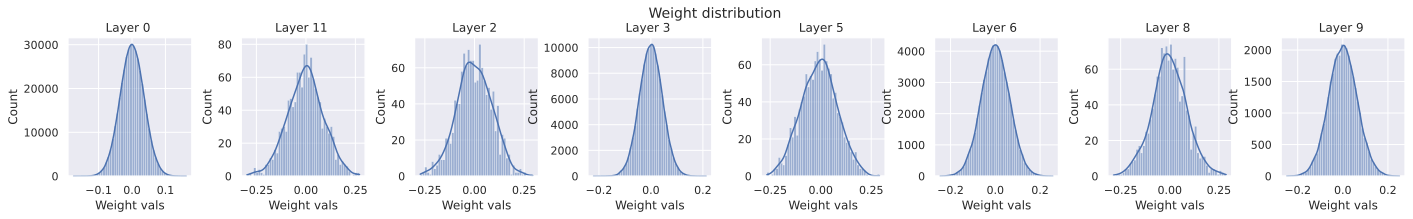

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1024x512 and 128x10)

In [27]:
def equal_var_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            param.data.normal_(std=1.0 / math.sqrt(param.shape[1]))


equal_var_init(model)
visualize_weight_distribution(model)
visualize_activations(model, print_variance=True)

분산 일정하게 유지.

- Xavier 초기화  
기울기와 분산의 균형을 맞춤.

In [28]:
def xavier_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            bound = math.sqrt(6) / math.sqrt(param.shape[0] + param.shape[1])
            param.data.uniform_(-bound, bound)


xavier_init(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1024x512 and 128x10)

In [29]:
# 비선형성 추가

model = BaseNetwork(act_fn=nn.Tanh()).to(device)
xavier_init(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1024x512 and 128x10)

분산은 깊이에 따라 감소, 활성화 분포 낮은 값에 집중  
-> 분산: 0.25부근에서 안정화 -> Tanh 네트워크에서 잘 작동  

ReLU의 경우라면...

In [30]:
def kaiming_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        elif name.startswith("layers.0"):  # The first layer does not have ReLU applied on its input
            param.data.normal_(0, 1 / math.sqrt(param.shape[1]))
        else:
            param.data.normal_(0, math.sqrt(2) / math.sqrt(param.shape[1]))


model = BaseNetwork(act_fn=nn.ReLU()).to(device)
kaiming_init(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1024x512 and 128x10)

### 최적화
- 옵티마이저: 기울기가 주어진 신경망의 파라미터 업데이트
- 학습률: 업데이트의 단계 크기. 높을수록 기울기 방향으로 가중치를 더 많이 변경, 작을수록 더 짧은 단계 수행.

In [31]:
def _get_config_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".config")


def _get_model_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".tar")


def _get_result_file(model_path, model_name):
    return os.path.join(model_path, model_name + "_results.json")


def load_model(model_path, model_name, net=None):
    config_file = _get_config_file(model_path, model_name)
    model_file = _get_model_file(model_path, model_name)
    assert os.path.isfile(
        config_file
    ), f'Could not find the config file "{config_file}". Are you sure this is the correct path and you have your model config stored here?'
    assert os.path.isfile(
        model_file
    ), f'Could not find the model file "{model_file}". Are you sure this is the correct path and you have your model stored here?'
    with open(config_file) as f:
        config_dict = json.load(f)
    if net is None:
        act_fn_name = config_dict["act_fn"].pop("name").lower()
        assert (
            act_fn_name in act_fn_by_name
        ), f'Unknown activation function "{act_fn_name}". Please add it to the "act_fn_by_name" dict.'
        act_fn = act_fn_by_name[act_fn_name]()
        net = BaseNetwork(act_fn=act_fn, **config_dict)
    net.load_state_dict(torch.load(model_file))
    return net


def save_model(model, model_path, model_name):
    config_dict = model.config
    os.makedirs(model_path, exist_ok=True)
    config_file = _get_config_file(model_path, model_name)
    model_file = _get_model_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
    torch.save(model.state_dict(), model_file)


def train_model(net, model_name, optim_func, max_epochs=50, batch_size=256, overwrite=False):
    """FashionMNIST의 훈련셋으로 모델 훈련

    Args:
        net: BaseNetwork의 객체
        model_name: (str) 체크포인트 이름을 만들 때 사용되는 모델의 이름
        max_epochs: 훈련할 때 (최대로) 반복할 횟수
        patience: 검증 세트로의 수행이 #parience 반복 동안 개선되지 않는다면, 훈련을 일찍 끝낸다.
        batch_size: 훈련에서 사용되는 배치 크기
        overwrite: 이미 체크포인트가 있을 때 케이스를 처리하는 방법을 결정. True이면 덮어씁니다. 그렇지 않으면 훈련을 건너뜁니다.
    """
    file_exists = os.path.isfile(_get_model_file(CHECKPOINT_PATH, model_name))
    if file_exists and not overwrite:
        print(f'Model file of "{model_name}" already exists. Skipping training...')
        with open(_get_result_file(CHECKPOINT_PATH, model_name)) as f:
            results = json.load(f)
    else:
        if file_exists:
            print("Model file exists, but will be overwritten...")

        # Defining optimizer, loss and data loader
        optimizer = optim_func(net.parameters())
        loss_module = nn.CrossEntropyLoss()
        train_loader_local = data.DataLoader(
            train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True
        )

        results = None
        val_scores = []
        train_losses, train_scores = [], []
        best_val_epoch = -1
        for epoch in range(max_epochs):
            train_acc, val_acc, epoch_losses = epoch_iteration(
                net, loss_module, optimizer, train_loader_local, val_loader, epoch
            )
            train_scores.append(train_acc)
            val_scores.append(val_acc)
            train_losses += epoch_losses

            if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
                print("\t   (New best performance, saving model...)")
                save_model(net, CHECKPOINT_PATH, model_name)
                best_val_epoch = epoch

    if results is None:
        load_model(CHECKPOINT_PATH, model_name, net=net)
        test_acc = test_model(net, test_loader)
        results = {
            "test_acc": test_acc,
            "val_scores": val_scores,
            "train_losses": train_losses,
            "train_scores": train_scores,
        }
        with open(_get_result_file(CHECKPOINT_PATH, model_name), "w") as f:
            json.dump(results, f)

    # Plot a curve of the validation accuracy
    sns.set()
    plt.plot([i for i in range(1, len(results["train_scores"]) + 1)], results["train_scores"], label="Train")
    plt.plot([i for i in range(1, len(results["val_scores"]) + 1)], results["val_scores"], label="Val")
    plt.xlabel("Epochs")
    plt.ylabel("Validation accuracy")
    plt.ylim(min(results["val_scores"]), max(results["train_scores"]) * 1.01)
    plt.title(f"Validation performance of {model_name}")
    plt.legend()
    plt.show()
    plt.close()

    print((f" Test accuracy: {results['test_acc']*100.0:4.2f}% ").center(50, "=") + "\n")
    return results


def epoch_iteration(net, loss_module, optimizer, train_loader_local, val_loader, epoch):
    ############
    # Training #
    ############
    net.train()
    true_preds, count = 0.0, 0
    epoch_losses = []
    t = tqdm(train_loader_local, leave=False)
    for imgs, labels in t:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = net(imgs)
        loss = loss_module(preds, labels)
        loss.backward()
        optimizer.step()
        # Record statistics during training
        true_preds += (preds.argmax(dim=-1) == labels).sum().item()
        count += labels.shape[0]
        t.set_description(f"Epoch {epoch+1}: loss={loss.item():4.2f}")
        epoch_losses.append(loss.item())
    train_acc = true_preds / count

    ##############
    # Validation #
    ##############
    val_acc = test_model(net, val_loader)
    print(
        f"[Epoch {epoch+1:2i}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {val_acc*100.0:05.2f}%"
    )
    return train_acc, val_acc, epoch_losses


def test_model(net, data_loader):
    """지정된 세트로 모델을 테스트한다.

    Args:
        net: BaseNetwork의 훈련된 모델
        data_loader: DataLoader object of the dataset to test on (validation or test)
    """
    net.eval()
    true_preds, count = 0.0, 0
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            preds = net(imgs).argmax(dim=-1)
            true_preds += (preds == labels).sum().item()
            count += labels.shape[0]
    test_acc = true_preds / count
    return test_acc

In [33]:
class OptimizerTemplate:
    def __init__(self, params, lr):
        self.params = list(params)
        self.lr = lr

    def zero_grad(self):
        # 모든 파라미터의 기울기를 0으로 설정
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_()  # For second-order optimizers important
                p.grad.zero_()

    @torch.no_grad()
    def step(self):
        # Apply update step to all parameters
        for p in self.params:
            if p.grad is None:  # We skip parameters without any gradients
                continue
            self.update_param(p)

    def update_param(self, p):
        # To be implemented in optimizer-specific classes
        raise NotImplementedError

In [34]:
# SGD
class SGD(OptimizerTemplate):
    def __init__(self, params, lr):
        super().__init__(params, lr)

    def update_param(self, p):
        p_update = -self.lr * p.grad
        p.add_(p_update)  # In-place update => saves memory and does not create computation graph

# SGE

In [35]:
class SGDMomentum(OptimizerTemplate):
    def __init__(self, params, lr, momentum=0.0):
        super().__init__(params, lr)
        self.momentum = momentum  # Corresponds to beta_1 in the equation above
        self.param_momentum = {p: torch.zeros_like(p.data) for p in self.params}  # Dict to store m_t

    def update_param(self, p):
        self.param_momentum[p] = (1 - self.momentum) * p.grad + self.momentum * self.param_momentum[p]
        p_update = -self.lr * self.param_momentum[p]
        p.add_(p_update)

In [36]:
class Adam(OptimizerTemplate):
    def __init__(self, params, lr, beta1=0.9, beta2=0.999, eps=1e-8):
        super().__init__(params, lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.param_step = {p: 0 for p in self.params}  # Remembers "t" for each parameter for bias correction
        self.param_momentum = {p: torch.zeros_like(p.data) for p in self.params}
        self.param_2nd_momentum = {p: torch.zeros_like(p.data) for p in self.params}

    def update_param(self, p):
        self.param_step[p] += 1

        self.param_momentum[p] = (1 - self.beta1) * p.grad + self.beta1 * self.param_momentum[p]
        self.param_2nd_momentum[p] = (1 - self.beta2) * (p.grad) ** 2 + self.beta2 * self.param_2nd_momentum[p]

        bias_correction_1 = 1 - self.beta1 ** self.param_step[p]
        bias_correction_2 = 1 - self.beta2 ** self.param_step[p]

        p_2nd_mom = self.param_2nd_momentum[p] / bias_correction_2
        p_mom = self.param_momentum[p] / bias_correction_1
        p_lr = self.lr / (torch.sqrt(p_2nd_mom) + self.eps)
        p_update = -p_lr * p_mom

        p.add_(p_update)

#### 모델 학습에 대한 옵티마이저 비교

ReLU 활성화 및 kaiming 초기화, 선형 네트워크 다시 사용.
> 주요 관심사: 옵티마이저가 심층신경망을 얼마나 잘 훈련시킬 수 있는가

In [37]:
base_model = BaseNetwork(act_fn=nn.ReLU(), hidden_sizes=[512, 256, 256, 128])
kaiming_init(base_model)

Model file of "FashionMNIST_SGD" already exists. Skipping training...


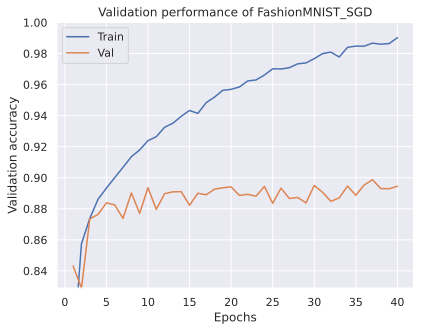

============= Test accuracy: 89.09% ==============



In [38]:
SGD_model = copy.deepcopy(base_model).to(device)
SGD_results = train_model(
    SGD_model, "FashionMNIST_SGD", lambda params: SGD(params, lr=1e-1), max_epochs=40, batch_size=256
)

Model file of "FashionMNIST_SGDMom" already exists. Skipping training...


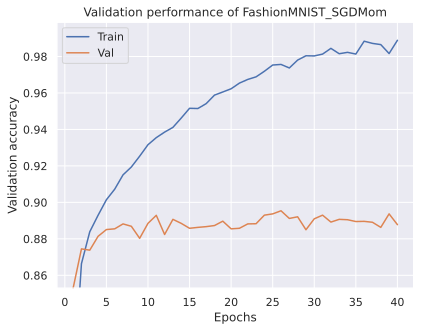

============= Test accuracy: 88.83% ==============



In [39]:
SGDMom_model = copy.deepcopy(base_model).to(device)
SGDMom_results = train_model(
    SGDMom_model,
    "FashionMNIST_SGDMom",
    lambda params: SGDMomentum(params, lr=1e-1, momentum=0.9),
    max_epochs=40,
    batch_size=256,
)

Model file of "FashionMNIST_Adam" already exists. Skipping training...


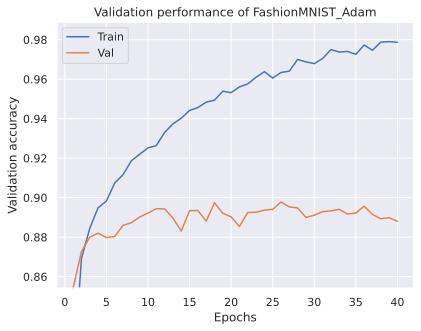

============= Test accuracy: 89.46% ==============



In [40]:
Adam_model = copy.deepcopy(base_model).to(device)
Adam_results = train_model(
    Adam_model, "FashionMNIST_Adam", lambda params: Adam(params, lr=1e-3), max_epochs=40, batch_size=256
)

모든 옵티마이저가 유사하게 잘 수행. (최기화에 기인한 결과일 수 있음.)  
하지만, 초기화를 상수 초기화와 같이 나쁘게 변경할 경우, Adam이 일반적으로 적응 학습률로 인해 좋음.

#### 병리학적 곡률
협곡과 유사한 표면을 가진 형태. SGD 최적화에 까다로움. (하나의 방향으로는 가파르지만, 다른 방향에서는 느린 기울기를 가짐.)

In [41]:
def pathological_curve_loss(w1, w2):
    # 병리학적 곡률의 예시. 더 많은 가능한 형태가 있으니 여기서 자유롭게 실험해보길!
    x1_loss = torch.tanh(w1) ** 2 + 0.01 * torch.abs(w1)
    x2_loss = torch.sigmoid(w2)
    return x1_loss + x2_loss

/home/min/miniconda3/envs/pytorch_lightning/lib/python3.10/site-packages/torch/functional.py:504: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)


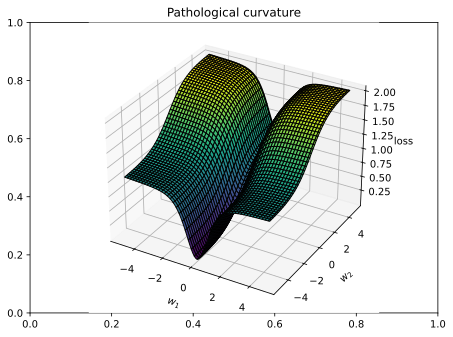

In [42]:
def plot_curve(
    curve_fn, x_range=(-5, 5), y_range=(-5, 5), plot_3d=False, cmap=cm.viridis, title="Pathological curvature"
):
    fig = plt.figure()
    ax = fig.gca()
    if plot_3d:
        ax = fig.add_subplot(projection="3d")

    x = torch.arange(x_range[0], x_range[1], (x_range[1] - x_range[0]) / 100.0)
    y = torch.arange(y_range[0], y_range[1], (y_range[1] - y_range[0]) / 100.0)
    x, y = torch.meshgrid([x, y])
    z = curve_fn(x, y)
    x, y, z = x.numpy(), y.numpy(), z.numpy()

    if plot_3d:
        ax.plot_surface(x, y, z, cmap=cmap, linewidth=1, color="#000", antialiased=False)
        ax.set_zlabel("loss")
    else:
        ax.imshow(z.T[::-1], cmap=cmap, extent=(x_range[0], x_range[1], y_range[0], y_range[1]))
    plt.title(title)
    ax.set_xlabel(r"$w_1$")
    ax.set_ylabel(r"$w_2$")
    plt.tight_layout()
    return ax


sns.reset_orig()
_ = plot_curve(pathological_curve_loss, plot_3d=True)
plt.show()

In [44]:
def train_curve(optimizer_func, curve_func=pathological_curve_loss, num_updates=100, init=[5, 5]):
    """
    Args:
        optimizer_func: 사용할 옵티마이저의 생성자. 매개변수 목록만 사용해야 함.
        curve_func: 손실 함수 (e.g. pathological curvature)
        num_updates: 최적화할 때 가질 스템의 수
        init: 파라미터 값 초기화. w_1 와 w_2를 표현하는 두 개의 요소를 가진 list/tuple이어야 함.
    Returns:
        Numpy array of shape [num_updates, 3] with [t,:2] being the parameter values at step t, and [t,2] the loss at t.
    """
    weights = nn.Parameter(torch.FloatTensor(init), requires_grad=True)
    optim = optimizer_func([weights])

    list_points = []
    for _ in range(num_updates):
        loss = curve_func(weights[0], weights[1])
        list_points.append(torch.cat([weights.data.detach(), loss.unsqueeze(dim=0).detach()], dim=0))
        optim.zero_grad()
        loss.backward()
        optim.step()
    points = torch.stack(list_points, dim=0).numpy()
    return points

In [45]:
SGD_points = train_curve(lambda params: SGD(params, lr=10))
SGDMom_points = train_curve(lambda params: SGDMomentum(params, lr=10, momentum=0.9))
Adam_points = train_curve(lambda params: Adam(params, lr=1))

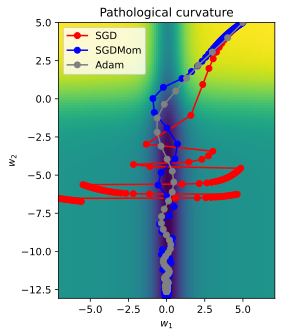

In [46]:
all_points = np.concatenate([SGD_points, SGDMom_points, Adam_points], axis=0)
ax = plot_curve(
    pathological_curve_loss,
    x_range=(-np.absolute(all_points[:, 0]).max(), np.absolute(all_points[:, 0]).max()),
    y_range=(all_points[:, 1].min(), all_points[:, 1].max()),
    plot_3d=False,
)
ax.plot(SGD_points[:, 0], SGD_points[:, 1], color="red", marker="o", zorder=1, label="SGD")
ax.plot(SGDMom_points[:, 0], SGDMom_points[:, 1], color="blue", marker="o", zorder=2, label="SGDMom")
ax.plot(Adam_points[:, 0], Adam_points[:, 1], color="grey", marker="o", zorder=3, label="Adam")
plt.legend()
plt.show()

#### 가파른 최적
주변에 매우 작은 기울기를 갖는 표면과 최적 주위의 매우 큰 기울기를 가지고 있음. 

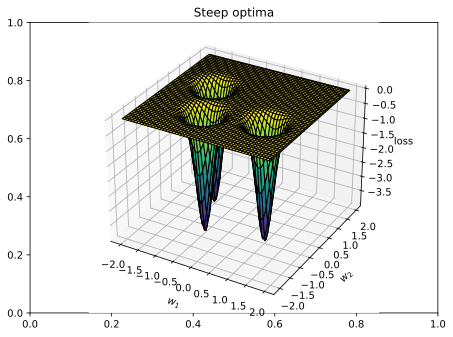

In [47]:
def bivar_gaussian(w1, w2, x_mean=0.0, y_mean=0.0, x_sig=1.0, y_sig=1.0):
    norm = 1 / (2 * np.pi * x_sig * y_sig)
    x_exp = (-1 * (w1 - x_mean) ** 2) / (2 * x_sig**2)
    y_exp = (-1 * (w2 - y_mean) ** 2) / (2 * y_sig**2)
    return norm * torch.exp(x_exp + y_exp)


def comb_func(w1, w2):
    z = -bivar_gaussian(w1, w2, x_mean=1.0, y_mean=-0.5, x_sig=0.2, y_sig=0.2)
    z -= bivar_gaussian(w1, w2, x_mean=-1.0, y_mean=0.5, x_sig=0.2, y_sig=0.2)
    z -= bivar_gaussian(w1, w2, x_mean=-0.5, y_mean=-0.8, x_sig=0.2, y_sig=0.2)
    return z


_ = plot_curve(comb_func, x_range=(-2, 2), y_range=(-2, 2), plot_3d=True, title="Steep optima")

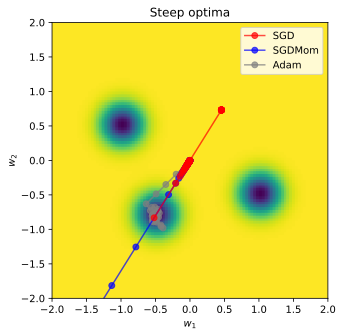

In [48]:
SGD_points = train_curve(lambda params: SGD(params, lr=0.5), comb_func, init=[0, 0])
SGDMom_points = train_curve(lambda params: SGDMomentum(params, lr=1, momentum=0.9), comb_func, init=[0, 0])
Adam_points = train_curve(lambda params: Adam(params, lr=0.2), comb_func, init=[0, 0])

all_points = np.concatenate([SGD_points, SGDMom_points, Adam_points], axis=0)
ax = plot_curve(comb_func, x_range=(-2, 2), y_range=(-2, 2), plot_3d=False, title="Steep optima")
ax.plot(SGD_points[:, 0], SGD_points[:, 1], color="red", marker="o", zorder=3, label="SGD", alpha=0.7)
ax.plot(SGDMom_points[:, 0], SGDMom_points[:, 1], color="blue", marker="o", zorder=2, label="SGDMom", alpha=0.7)
ax.plot(Adam_points[:, 0], Adam_points[:, 1], color="grey", marker="o", zorder=1, label="Adam", alpha=0.7)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
plt.legend()
plt.show()